In [1]:
#import required libraries
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt

In [2]:
# import data 
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
data = pd.read_excel(url)

# Check data info
print(data.head())

print(data.tail())

print(data.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
       InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S A

In [3]:
# noticed that CustomerID has NA, remove data contain NA
data= data[pd.notnull(data['CustomerID'])]

In [4]:
# remove duplicate data
filtered_data=data[['Country','CustomerID']].drop_duplicates()

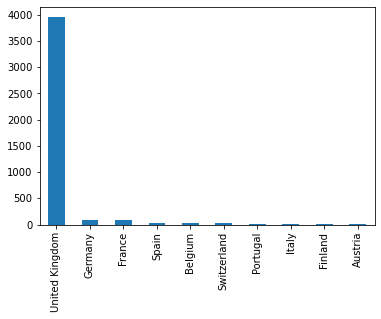

In [5]:
#Top ten country's customer
filtered_data.Country.value_counts()[:10].plot(kind='bar')

In [6]:
# select only UK data
uk_data=data[data.Country=='United Kingdom']
print(uk_data.info())
print(uk_data.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361878 non-null  object        
 1   StockCode    361878 non-null  object        
 2   Description  361878 non-null  object        
 3   Quantity     361878 non-null  int64         
 4   InvoiceDate  361878 non-null  datetime64[ns]
 5   UnitPrice    361878 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      361878 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB
None
            Quantity      UnitPrice     CustomerID
count  361878.000000  361878.000000  361878.000000
mean       11.077029       3.256007   15547.871368
std       263.129266      70.654731    1594.402590
min    -80995.000000       0.000000   12346.000000
25%         2.000000       1.250000   14194.0000

In [7]:
# remove Quantity that less than 0
uk_data = uk_data[(uk_data['Quantity']>0)]
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    354345 non-null  object        
 1   StockCode    354345 non-null  object        
 2   Description  354345 non-null  object        
 3   Quantity     354345 non-null  int64         
 4   InvoiceDate  354345 non-null  datetime64[ns]
 5   UnitPrice    354345 non-null  float64       
 6   CustomerID   354345 non-null  float64       
 7   Country      354345 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.3+ MB


In [8]:
# select columns needed for the analysis
uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

In [9]:
# Calculate total price from quantity and unit price
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']

In [10]:
# check invoice date
print(uk_data['InvoiceDate'].min())
print(uk_data['InvoiceDate'].max())
# set current date as one day after the last date in the dataset
PRESENT = dt.datetime(2011,12,10)
# change the date formate
uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])
uk_data.head()

2010-12-01 08:26:00
2011-12-09 12:49:00


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [11]:
# calculate rfm values using lambda
rfm= uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'TotalPrice': lambda price: price.sum()})

In [12]:
# column names before
print(rfm.columns)

# Change the name of columns
rfm.columns=['recency','frequency','monetary']

# column names after
print(rfm.columns)

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')
Index(['recency', 'frequency', 'monetary'], dtype='object')


In [13]:
# assign rfm scores based on values
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

In [14]:
# combined score
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.sample(10)

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
17152.0,194,14,1689.50,4,4,1,441
16081.0,56,227,2806.90,3,1,1,311
15866.0,101,45,230.53,3,2,4,324
17885.0,12,64,190.19,1,2,4,124
15223.0,225,20,755.75,4,3,2,432
16926.0,371,14,230.25,4,4,4,444
13477.0,37,79,1454.58,2,2,2,222
14109.0,72,9,144.20,3,4,4,344
17345.0,15,87,537.74,1,2,3,123
